In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
# 1. Prerequisite
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


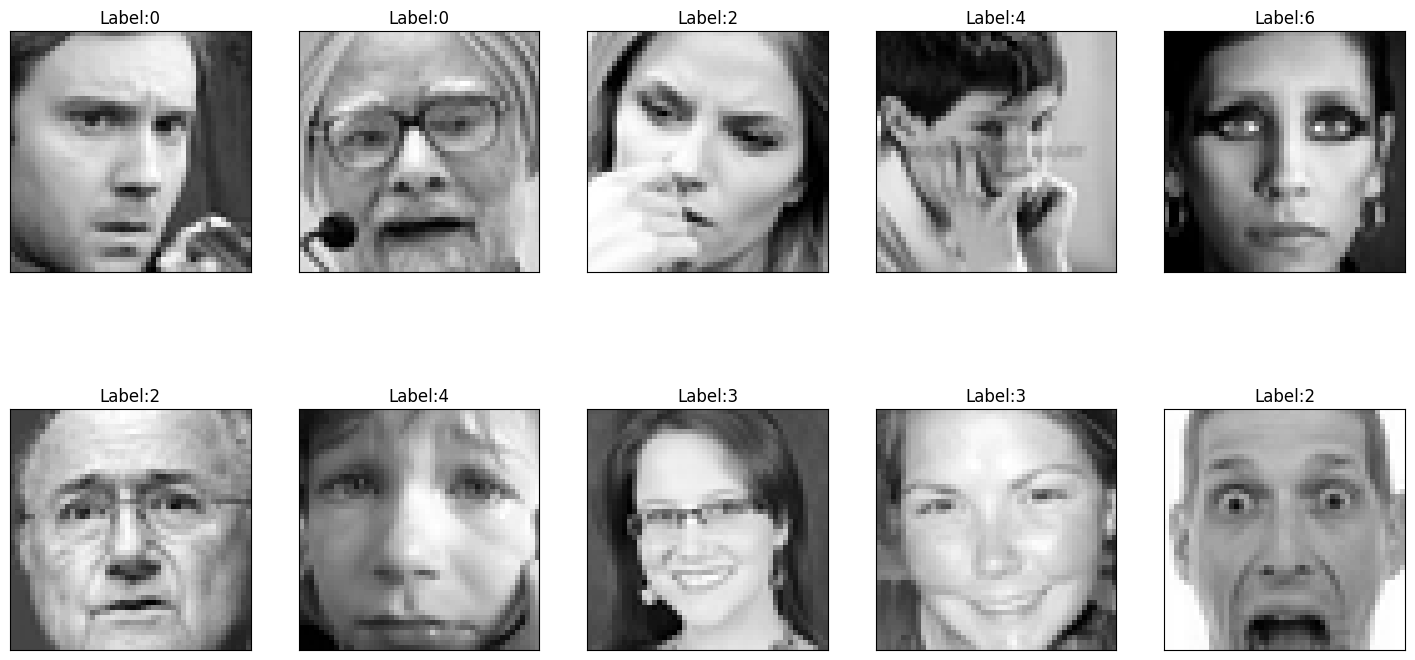

In [ ]:
# Parse data
images, labels = parse_data(df)

# Show images
show_img(images, labels)

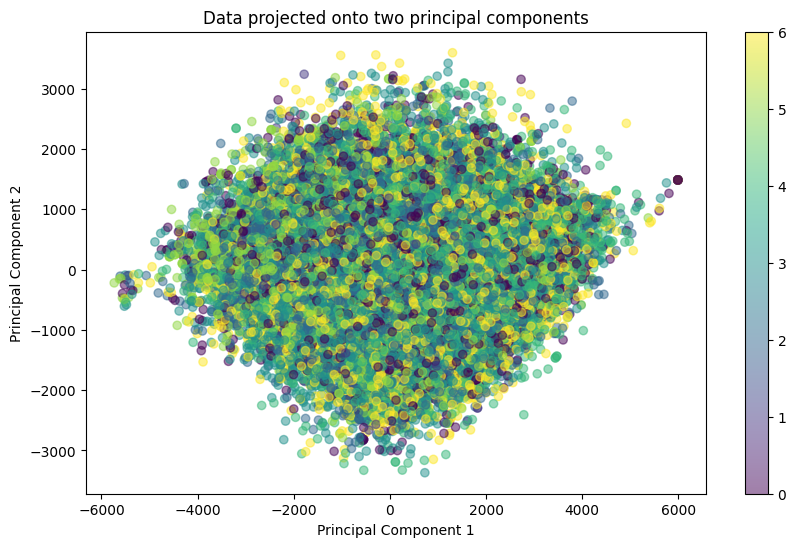

In [ ]:
# Biến đổi hình ảnh từ (số lượng ảnh, 48, 48) thành (số lượng ảnh, 48*48)
images_flattened = images.reshape(images.shape[0], -1)

pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_flattened)

plt.figure(figsize=(10, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data projected onto two principal components')
plt.show()

In [ ]:
def optimal_pca_components(images):

    #fit PCA
    pca_full = PCA().fit(images)

    # Tính tổng phương sai được giải thích tích lũy
    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Xác định số lượng thành phần chính tối ưu
    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance vs. Number of Principal Components')
    plt.axvline(optimal_components - 1, color='r', linestyle='--', label=f'Optimal components: {optimal_components}')
    plt.axhline(0.95, color='g', linestyle='--', label='95% variance')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f'Optimal number of principal components: {optimal_components}')

    return optimal_components

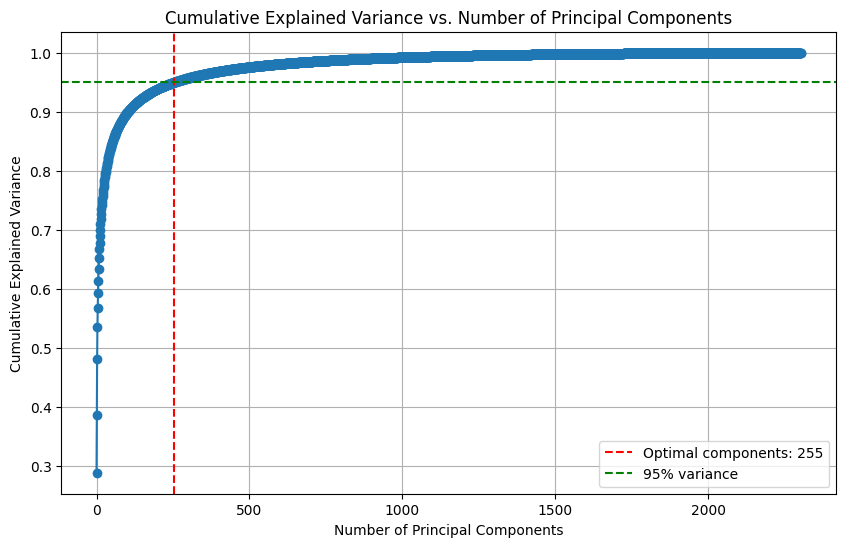

Optimal number of principal components: 255


In [ ]:
optimal_components = optimal_pca_components(images_flattened)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components = optimal_components)

X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth' : [10, 15],
    'min_samples_split': [10, 20]
}

In [ ]:
def evaluate_model(X_train, X_test, y_train, y_test, param_grid):
    grid = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced', random_state=42), param_grid=param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best parameters: {grid.best_params_}")

    y_pred = grid.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    return y_pred, accuracy, precision, recall, f1

In [ ]:
#Chạy mô hình với tập dữ liệu không PCA
print("Case: Scaled data (no PCA)")
y_pred_scaled, acc_scaled, prec_scaled, rec_scaled, f1_scaled = evaluate_model(X_train_scaled, X_test_scaled, y_train, y_test, param_grid)

Case: Scaled data (no PCA)
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best parameters: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy: 0.45611590972415716
Precision: 0.45887106137563793
Recall: 0.45611590972415716
F1 Score: 0.4440914696722428

Classification report:
              precision    recall  f1-score   support

           0       0.48      0.24      0.32       985
           1       0.95      0.37      0.54       102
           2       0.44      0.29      0.35      1043
           3       0.49      0.67      0.57      1765
           4       0.35      0.39      0.37      1210
           5       0.55      0.62      0.58       795
           6       0.43      0.43      0.43      1278

    accuracy                           0.46      7178
   macro avg       0.53      0.43      0.45      7178
weighted avg       0.46      0.46      0.44      7178



In [ ]:
#Chạy mô hình với tập dữ liệu có PCA
print("Case: Scaled and PCA-transformed data")
y_pred_scaled_pca, acc_scaled_pca, prec_scaled_pca, rec_scaled_pca, f1_scaled_pca = evaluate_model(X_train_scaled_pca, X_test_scaled_pca, y_train, y_test, param_grid)

Case: Scaled and PCA-transformed data
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best parameters: {'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 300}
Accuracy: 0.4109779882975759
Precision: 0.4089932347534562
Recall: 0.4109779882975759
F1 Score: 0.3985059858586677

Classification report:
              precision    recall  f1-score   support

           0       0.39      0.20      0.26       985
           1       0.89      0.32      0.47       102
           2       0.39      0.27      0.32      1043
           3       0.46      0.62      0.53      1765
           4       0.32      0.37      0.34      1210
           5       0.50      0.58      0.54       795
           6       0.36      0.34      0.35      1278

    accuracy                           0.41      7178
   macro avg       0.47      0.39      0.40      7178
weighted avg       0.41      0.41      0.40      7178



In [ ]:
#Tạo bảng kết quả
data = [
    ['Scaled Data (no PCA)', acc_scaled, prec_scaled, rec_scaled, f1_scaled],
    ['Scaled and PCA-Transformed Data', acc_scaled_pca, prec_scaled_pca, rec_scaled_pca, f1_scaled_pca]
]

df_results = pd.DataFrame(data, columns=['Case', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

print(df_results)

                              Case  Accuracy  Precision    Recall  F1 Score
0             Scaled Data (no PCA)  0.456116   0.458871  0.456116  0.444091
1  Scaled and PCA-Transformed Data  0.410978   0.408993  0.410978  0.398506


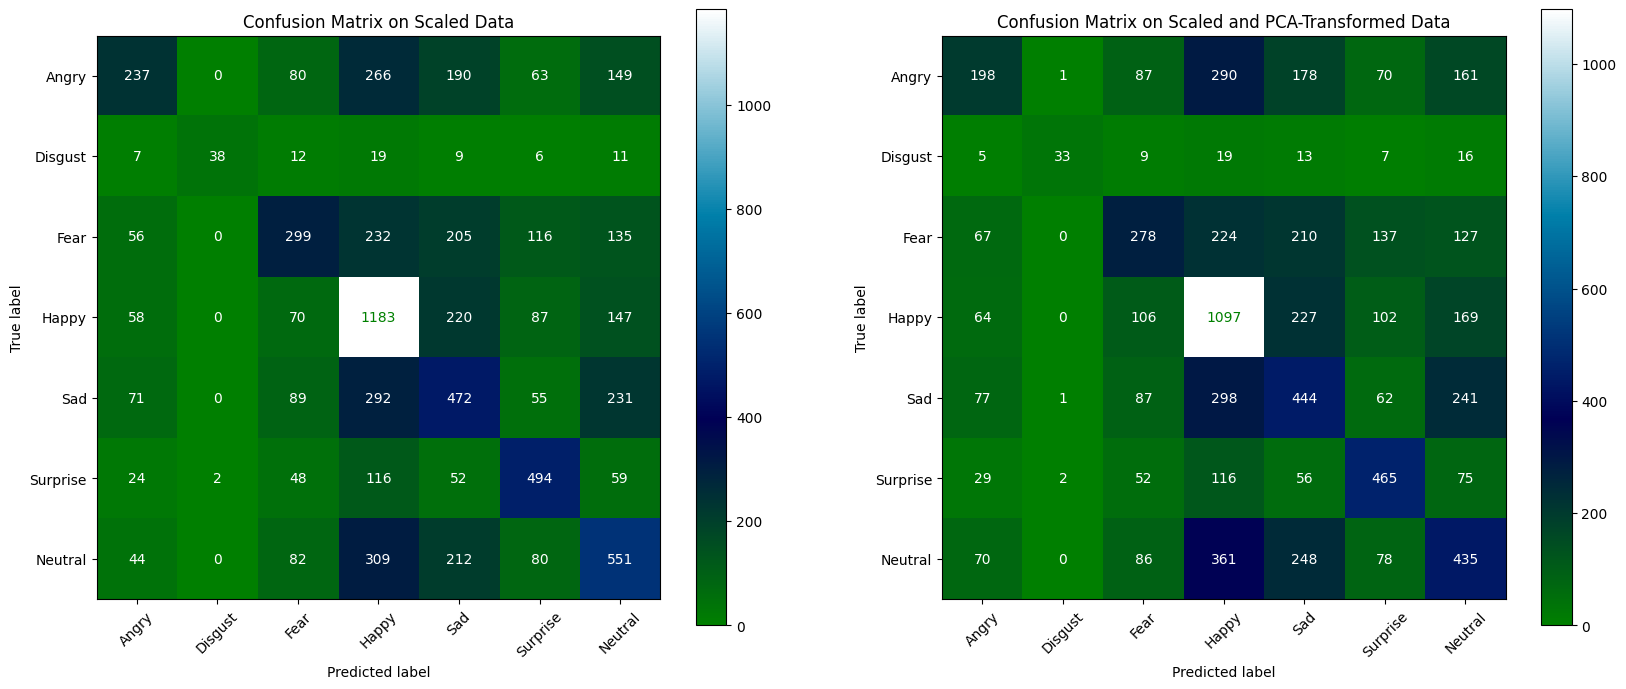

In [ ]:
#Vẽ ma trận nhầm lẫn
conf_matrix_scaled = confusion_matrix(y_test, y_pred_scaled)
conf_matrix_scaled_pca = confusion_matrix(y_test, y_pred_scaled_pca)

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
disp_scaled = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_scaled, display_labels=class_names)
disp_scaled_pca = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_scaled_pca, display_labels=class_names)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Ma trận nhầm lẫn cho dữ liệu gốc
disp_scaled.plot(ax=axes[0], xticks_rotation='vertical', cmap='ocean')
axes[0].set_title('Confusion Matrix on Scaled Data')
axes[0].set_xticks(np.arange(len(class_names)))
axes[0].set_xticklabels(class_names, rotation=45)
axes[0].set_yticks(np.arange(len(class_names)))
axes[0].set_yticklabels(class_names)

# Ma trận nhầm lẫn cho dữ liệu PCA
disp_scaled_pca.plot(ax=axes[1], xticks_rotation='vertical', cmap='ocean')
axes[1].set_title('Confusion Matrix on Scaled and PCA-Transformed Data')
axes[1].set_xticks(np.arange(len(class_names)))
axes[1].set_xticklabels(class_names, rotation=45)
axes[1].set_yticks(np.arange(len(class_names)))
axes[1].set_yticklabels(class_names)

plt.show()



---



### **Question 2: How to determine the optimal number of principal components using pca.explained_variance_? Explain your selection process.**

Để xác định số lượng thành phần chính tối ưu, chúng ta sử dụng phương pháp PCA và hàm explained_variance_ratio_ của PCA:
Thực hiện phân tích thành phần chính (PCA) trên toàn bộ tập dữ liệu. Sử dụng explained_variance_ratio_ để tính tổng phương sai được giải thích tích lũy bởi các thành phần chính.
Tại đây, chọn xác định số lượng thành phần chính tối ưu sao cho tổng phương sai tích lũy đạt ít nhất 95%. Kết quả cho thấy số lượng thành phần chính tối ưu là 255, tức là cần 255 thành phần chính để giải thích ít nhất 95% phương sai của dữ liệu

## **Kết luận**

Sử dụng mô hình **RandomForest** và áp dụng GridSearchCV để tinh chỉnh siêu tham số trên hai trường hợp:

**Dữ liệu đã được scale nhưng không áp dụng PCA:**

Các tham số tốt nhất: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 300}

Hiệu suất:


*   Độ chính xác (Accuracy): 0.4561
*   Độ chính xác (Precision): 0.4589
*   Độ nhạy (Recall): 0.4561
*   F1 Score: 0.4441


**Dữ liệu đã được scale và áp dụng PCA:**

Các tham số tốt nhất: {'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 300}

Hiệu suất:

*   Độ chính xác (Accuracy): 0.4110
*   Độ chính xác (Precision): 0.4090
*   Độ nhạy (Recall): 0.4110
*   F1 Score: 0.3985

**So sánh hiệu suất hai mô hình:**
- Scaled Data (no PCA): Accuracy 0.4561
- Scaled and PCA-Transformed Data: Accuracy: 0.4110

Scaled Data (no PCA) có hiệu suất tổng thể tốt hơn với tất cả các chỉ số: Accuracy, Precision, Recall, và F1 Score đều cao hơn so với dữ liệu có áp dụng PCA. Dữ liệu không áp dụng PCA giữ nguyên tất cả các thông tin gốc của dữ liệu, giúp mô hình học được nhiều đặc trưng hơn, trong khi dữ liệu có áp dụng PCA giảm số chiều và có thể mất mát một số thông tin quan trọng dẫn đến hiệu suất kém hơn.

Trong trường hợp tập dữ liệu mất cân đối khi số lượng mẫu của các lớp không đồng đều, việc sử dụng tham số ***class_weight='balanced'*** trong mô hình RandomForestClassifier sẽ tự động điều chỉnh trọng số của các lớp sao cho lớp thiểu số có trọng số lớn hơn và lớp chiếm ưu thế có trọng số nhỏ hơn, giúp cân bằng ảnh hưởng của các lớp và có thể cải thiện hiệu suất của mô hình.

Khi mô hình chỉ học tốt trên các lớp chiếm ưu thế mà bỏ qua các lớp thiểu số, nó có thể dẫn đến overfitting trên các lớp chiếm ưu thế. Bằng cách cân bằng trọng số, mô hình được khuyến khích học cả các lớp thiểu số, làm giảm nguy cơ gặp hiện tượng overfitting.




---


### **Xét về phân loại cảm xúc**

**Dữ liệu đã được scale nhưng không áp dụng PCA:**


*   Cảm xúc 0: Precision, Recall và F1-Score đều thấp nhất, đây là cảm xúc sai nhiều nhất.
*   Cảm xúc 1: Precision cao nhưng Recall thấp, chỉ số F1-Score tương đối cao. Có thể dễ nhận diện nhưng không nhất quán.
*   Cảm xúc 2: Các chỉ số tương đối thấp, gặp khó khăn trong việc nhận diện.
*   Cảm xúc 3: Recall cao nhất và F1-Score cao, cho thấy mô hình nhận diện cảm xúc này khá tốt.
*   Cảm xúc 4: Các chỉ số trung bình, không quá khó khăn nhưng cũng không quá dễ dàng.
*   Cảm xúc 5: F1-Score cao nhất, là cảm xúc dễ nhận diện nhất.
*   Cảm xúc 6: Các chỉ số tương đối đồng đều, nằm ở mức trung bình.


**Dữ liệu đã được scale và áp dụng PCA:**



*   Cảm xúc 0: Precision và Recall đều thấp, F1-Score rất thấp, đây vẫn là cảm xúc sai nhiều nhất.
*   Cảm xúc 1: Precision cao, Recall thấp, F1-Score tương đối cao. Có thể dễ nhận diện nhưng không nhất quán.
*   Cảm xúc 2: Các chỉ số tương đối thấp, gặp khó khăn trong việc nhận diện.
*   Cảm xúc 3: Recall cao và F1-Score khá cao, mô hình nhận diện tốt cảm xúc này.
*   Cảm xúc 4: Các chỉ số trung bình, không quá khó khăn nhưng cũng không dễ dàng.
*   Cảm xúc 5: F1-Score cao nhất, là cảm xúc dễ nhận diện nhất.
*   Cảm xúc 6: Các chỉ số tương đối đồng đều, nằm ở mức trung bình.

**Kết luận:**


*   **Cảm xúc dễ nhận diện nhất:** Trong cả hai trường hợp, Cảm xúc 5 luôn có F1-Score cao nhất, là cảm xúc dễ nhận diện nhất.
*   **Cảm xúc sai nhiều nhất:** Cảm xúc 0 vẫn là cảm xúc có Precision, Recall và F1-Score thấp nhất, là cảm xúc bị sai nhiều nhất trong cả hai trường hợp.
























